# Model v1.4

## Leaderboard score: 1.28702

In [1]:
from keras.layers import Input, LSTM, Dense, Dropout, Embedding, TimeDistributed, Reshape
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate

In [3]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [4]:
import tensorflow as tf
from keras import backend as K

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [6]:
from sklearn_pandas import DataFrameMapper

In [7]:
import pandas as pd
import numpy as np

In [8]:
from keras.utils.np_utils import to_categorical

In [140]:
version = 1.4
version_str = "v" + str(version)

In [11]:
LABEL = "price_doc"

In [12]:
def prepare_dataset(df, test=False, trunc_fields=False):
    global LABEL
    t_fields = ['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor','material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', LABEL]
    
    if not test:
        if trunc_fields:
            df = df[t_fields.append + LABEL]
        else:
            df = df
    else:
        if trunc_fields:
            df = df[t_fields]
        else:
            df = df
    
    df['timestamp_converted'] = pd.to_datetime(df['timestamp'])
    df['timestamp_day'] = df.apply(lambda row: row['timestamp_converted'].day, axis=1)
    df['timestamp_month'] = df.apply(lambda row: row['timestamp_converted'].month, axis=1)
    df['timestamp_year'] = df.apply(lambda row: row['timestamp_converted'].year, axis=1)
    df['state_refractored'] = df.apply( lambda row: 5 if row['state'] == 33 else row['state'] , axis = 1)
    
    df = df.fillna(0)
    
    df['state_refractored'] = df['state_refractored'].astype(int)    
    df['material'] = df['material'].astype(int)    
    return df

In [72]:
final_train_df = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/final_training_dataset.csv")

In [73]:
final_train_df = prepare_dataset(final_train_df)

In [74]:
del final_train_df['Unnamed: 0']

In [75]:
final_train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,1,2011-08-20,43,27.0,4.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2,2011-08-23,34,19.0,3.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,3,2011-08-27,43,29.0,2.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,4,2011-09-01,89,50.0,9.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,5,2011-09-05,77,77.0,4.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


## Data prep

In [76]:
def dedup(listy):
    return list(set(listy))

In [77]:
property_columns = [
    # Place features
 'full_sq',
 'kitch_sq',
 'floor',
 'life_sq',
 'build_year',
 'num_room',
 'max_floor',
 'sub_area',
]

time_columns = [
 'timestamp_day',
 'timestamp_month',
 'timestamp_year',
]

population_columns = [
    # Economy: Population
    'male_f',
    'female_f',
    'young_all',
    'young_male',
    'young_female',
    'work_all',
    'work_male',
    'work_female',
    'ekder_all',
    'ekder_male',
    'ekder_female',
    
    'marriages_per_1000_cap',
    'divorce_rate',
    'pop_natural_increase',
    'pop_migration',
    'pop_total_inc',
    'childbirth',
    'mortality',
    'average_life_exp',
]

locality_columns = [
 'metro_min_avto',
    
 'railroad_station_avto_min',
    
 'green_part_1000',
 'green_part_1500',
    
     # Raion = number of...
  'big_market_raion',
  'nuclear_reactor_raion',
  'detention_facility_raion',
  'full_all',
  'shopping_centers_raion',
  'office_raion',
  'thermal_power_plant_raion',
  'healthcare_centers_raion',
  'university_top_20_raion',
    
  # Locality features...
 'railroad_km',
 'green_zone_km',
 'kindergarten_km',
 'public_transport_station_km',
 'metro_km_avto',
 'park_km',
 'cemetery_km',
 'mosque_km',
 'public_healthcare_km',
 'catering_km',
 'big_road2_km',
 'hospice_morgue_km',
 'swim_pool_km',
 'water_treatment_km',
 'power_transmission_line_km',
 'water_km',
 'school_km',
 'ttk_km',
 'area_m',
 'ts_km',
 'university_km',
 'oil_chemistry_km',
 'exhibition_km',
 'shopping_centers_km',
 'zd_vokzaly_avto_km',
 'preschool_km',
 'big_road1_km',
 'additional_education_km',
 'church_synagogue_km',
 'big_church_km',
 'incineration_km',
 'industrial_km',
 'nuclear_reactor_km',
]

economy_columns = [
    
    
     'usdrub',
 'micex_cbi_tr',
 'brent', 
    
     'micex',
    
    'oil_urals',
     
 # Economy features
 'gdp_quart',
 'gdp_quart_growth',
 'cpi',
    'ppi',
    'gdp_deflator',
    'gdp_annual',
    'gdp_annual_growth',
    'average_provision_of_build_contract',
    'average_provision_of_build_contract_moscow',
    'rts',
    'deposits_value',
    'deposits_growth',
    'deposits_rate',
    'mortgage_value',
    'mortgage_growth',
    'mortgage_rate',
    'grp',
    'grp_growth',
    'income_per_cap',
    'real_dispos_income_per_cap_growth',
    'salary',
    'salary_growth',
    'labor_force',
    'unemployment',
    'employment',
    'construction_value',
    'housing_fund_sqm',
    'lodging_sqm_per_cap',
    'water_pipes_share',
    'baths_share',
    'sewerage_share',
    'gas_share',
    'hot_water_share',
    'electric_stove_share',
    'heating_share',
    'old_house_share',
    'incidence_population',
    'rent_price_4+room_bus',
    'rent_price_3room_bus',
    'rent_price_2room_bus',
    'rent_price_1room_bus',
    'rent_price_3room_eco',
    'rent_price_2room_eco',
    'rent_price_1room_eco',
    'apartment_build',
    'apartment_fund_sqm',
    'indust_part',
]

one_hot_cols = [
    'material',
    'state_refractored'
]

columns = dedup(property_columns + population_columns + economy_columns + locality_columns + time_columns + one_hot_cols)

label_cols = [
    'sub_area',
    'big_market_raion',
    'nuclear_reactor_raion',
    'thermal_power_plant_raion',
    'detention_facility_raion',
    'big_market_raion',
  'nuclear_reactor_raion',
  'detention_facility_raion',
  'full_all',
  'shopping_centers_raion',
  'office_raion',
  'thermal_power_plant_raion',
  'healthcare_centers_raion',
  'university_top_20_raion',
]

exclude_normalize_columns = [
    # Specific columns to exclude...
] + one_hot_cols + label_cols

normalize_columns = [c for c in columns if c not in exclude_normalize_columns]

#locality_columns = [c for c in columns if "_km" in c]
continuous_columns = [c for c in columns if c not in one_hot_cols and c not in label_cols]
continuous_columns_without_locality = [c for c in continuous_columns if c not in locality_columns]

In [78]:
final_train_df = final_train_df[columns + [LABEL, 'timestamp_converted']]

In [79]:
final_train_df.head()

,micex_cbi_tr,unemployment,apartment_build,railroad_station_avto_min,rts,pop_migration,work_all,state_refractored,healthcare_centers_raion,max_floor,...,salary,cpi,rent_price_4+room_bus,micex,rent_price_3room_bus,average_provision_of_build_contract_moscow,average_life_exp,marriages_per_1000_cap,price_doc,timestamp_converted
0,204.78,0.014,23587.0,6.905893,1575.33,5.1,98207,0,1,0.0,...,44898.7,354.0,136.11,1438.74,77.93,6.74,75.79,8.5,5850000,2011-08-20
1,204.92,0.014,23587.0,4.679745,1578.91,5.1,70194,0,1,0.0,...,44898.7,354.0,136.11,1444.11,77.93,6.74,75.79,8.5,6000000,2011-08-23
2,204.84,0.014,23587.0,1.701420,1596.17,5.1,63388,0,1,0.0,...,44898.7,354.0,136.11,1458.84,77.93,6.74,75.79,8.5,5700000,2011-08-27
3,205.42,0.014,23587.0,5.271136,1703.86,5.1,120381,0,1,0.0,...,44898.7,353.2,155.22,1551.58,94.02,6.74,75.79,8.5,13100000,2011-09-01
4,198.24,0.014,23587.0,2.156284,1617.01,5.1,68043,0,4,0.0,...,44898.7,353.2,155.22,1492.83,94.02,6.74,75.79,8.5,16331452,2011-09-05


In [80]:
final_train_df = final_train_df.convert_objects(convert_numeric=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


## Prepare numeric data scalers & normalizers

In [81]:
norm_scalers = {column : preprocessing.StandardScaler() for column in normalize_columns}

In [82]:
norm_scalers

{'additional_education_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'apartment_build': StandardScaler(copy=True, with_mean=True, with_std=True),
 'apartment_fund_sqm': StandardScaler(copy=True, with_mean=True, with_std=True),
 'area_m': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_life_exp': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_provision_of_build_contract': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_provision_of_build_contract_moscow': StandardScaler(copy=True, with_mean=True, with_std=True),
 'baths_share': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_church_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_road1_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_road2_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'brent': StandardScaler(copy=True, with_mean=True, with_std=True),
 'build_year': StandardScaler(copy=T

In [83]:
len(norm_scalers)

118

In [84]:
ont_hot_scalers = {column : (preprocessing.LabelEncoder(), preprocessing.OneHotEncoder(sparse=False)) for column in one_hot_cols}

In [85]:
ont_hot_scalers

{'material': (LabelEncoder(),
  OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
         handle_unknown='error', n_values='auto', sparse=False)),
 'state_refractored': (LabelEncoder(),
  OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
         handle_unknown='error', n_values='auto', sparse=False))}

In [86]:
label_scalers = {column : preprocessing.LabelEncoder() for column in label_cols}

In [87]:
label_scalers

{'big_market_raion': LabelEncoder(),
 'detention_facility_raion': LabelEncoder(),
 'full_all': LabelEncoder(),
 'healthcare_centers_raion': LabelEncoder(),
 'nuclear_reactor_raion': LabelEncoder(),
 'office_raion': LabelEncoder(),
 'shopping_centers_raion': LabelEncoder(),
 'sub_area': LabelEncoder(),
 'thermal_power_plant_raion': LabelEncoder(),
 'university_top_20_raion': LabelEncoder()}

In [88]:
for column in normalize_columns:
    c_scaler = norm_scalers[column]
    try:
        c_scaler.fit(final_train_df[[column]].values)
    except:
        print 'failed: ', column

In [89]:
for column in one_hot_cols:
    label_enc, one_hot_enc = ont_hot_scalers[column]
    r = label_enc.fit_transform(final_train_df[[column]].values)
    r = np.expand_dims(r, axis=1)
    one_hot_enc.fit(r)

In [90]:
for column in label_cols:
    label_enc = label_scalers[column]
    label_enc.fit(final_train_df[[column]].values)

### Test the scalers...

In [91]:
norm_scalers['timestamp_day'].transform([final_train_df.ix[0]['timestamp_day']])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.40933319])

In [92]:
ont_hot_scalers['material'][1].transform([final_train_df.ix[70]['material']])

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [93]:
label_scalers['sub_area'].transform([final_train_df.ix[0]['sub_area']])

array([9])

In [94]:
sub_area_metadata = open('/mnt/h/Kaggle/Competitions/Russian Bank/models/metadata/sub_area_metadata.tsv', 'w+')
sub_area_metadata.write("Sub area\n" + "\n".join([label_scalers['sub_area'].inverse_transform([i])[0] for i in range(146)]))
sub_area_metadata.close()

### Save them to disk

In [95]:
from sklearn.externals import joblib

In [96]:
joblib.dump(norm_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/norm_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/norm_scalers.pkl']

In [97]:
joblib.dump(ont_hot_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/one_hot_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/one_hot_scalers.pkl']

In [98]:
joblib.dump(label_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/label_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/label_scalers.pkl']

### Transform the whole training data

In [99]:
for continuous_norm_col in normalize_columns:
    scaler = norm_scalers[continuous_norm_col]
    scaled_values = scaler.transform(final_train_df[[continuous_norm_col]].values)
    final_train_df[continuous_norm_col + "_scaled_feature"] = scaled_values

In [100]:
for one_hot_col in one_hot_cols:
    l_scaler = ont_hot_scalers[one_hot_col][0]
    scaler = ont_hot_scalers[one_hot_col][1]
    r = l_scaler.transform(final_train_df[[one_hot_col]].values)
    r = np.expand_dims(r, axis=1)
    scaled_values = scaler.transform(r)
    final_train_df[one_hot_col + "_scaled_feature"] = list(scaled_values)

In [101]:
for label_col in label_cols:
    label_enc = label_scalers[label_col]
    encoded_values = label_enc.transform(final_train_df[[label_col]].values)
    final_train_df[label_col + "_scaled_feature"] = encoded_values

In [102]:
def extract_normalized_feature(df, feature_name):
    return np.array(df[feature_name + "_scaled_feature"].values.tolist())

In [103]:
extract_normalized_feature(final_train_df, "full_sq")

array([-0.29487286, -0.53152276, -0.29487286, ..., -0.24228399,
        0.25731024, -0.29487286])

In [104]:
extract_normalized_feature(final_train_df, "life_sq")

array([-0.00404841, -0.16882931,  0.03714682, ..., -0.56018395,
        0.09893965,  0.0165492 ])

In [105]:
extract_normalized_feature(final_train_df, "sub_area")

array([  9,  70, 129, ..., 103,  77,  75])

In [106]:
locality_columns[0], extract_normalized_feature(final_train_df, locality_columns[0])

('metro_min_avto',
 array([-0.36180133, -0.61411914, -0.43340412, ..., -0.42855279,
        -0.24162376, -0.66784139]))

In [107]:
extract_normalized_feature(final_train_df, "sub_area")

array([  9,  70, 129, ..., 103,  77,  75])

In [108]:
def extract_temporal_features(df):
    global time_columns
    vals = []
    for c in time_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [109]:
def extract_property_place_features(df):
    global property_columns
    vals = []
    for c in property_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [110]:
def extract_economy_features(df):
    global economy_columns
    vals = []
    for c in economy_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [111]:
def extract_population_features(df):
    global population_columns
    vals = []
    for c in population_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [112]:
def extract_locality_features(df):
    global locality_columns
    vals = []
    for c in locality_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [113]:
def extract_categorical_features(df):
    global one_hot_cols, label_cols
    vals = {}
    for c in one_hot_cols + label_cols:
        vals[c]  = extract_normalized_feature(df, c)
    return vals

In [114]:
#extract_continuous_features(final_train_df).shape # 51 + 3 (one hot columns) + 1 (label) = 55 (total dataframe columns excluding id)...

In [115]:
extract_locality_features(final_train_df).shape

(30471, 46)

In [116]:
extract_categorical_features(final_train_df)

{'big_market_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'detention_facility_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'full_all': array([78, 59, 89, ..., 18, 73, 54]),
 'healthcare_centers_raion': array([1, 1, 1, ..., 0, 2, 2]),
 'material': array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]]),
 'nuclear_reactor_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'office_raion': array([1, 0, 1, ..., 0, 5, 1]),
 'shopping_centers_raion': array([13,  3,  0, ...,  1,  4,  5]),
 'state_refractored': array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.]]),
 'sub_area': array([  9,  7

### Generate LSTM timestep input data

In [117]:
timesteps = 3

In [121]:
final_train_df['timestamp_converted'] = pd.to_datetime(final_train_df['timestamp_converted'])

In [127]:
final_train_df.sort('timestamp_converted')[['timestamp_converted', 'price_doc']]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,timestamp_converted,price_doc
0,2011-08-20,5850000
1,2011-08-23,6000000
2,2011-08-27,5700000
3,2011-09-01,13100000
4,2011-09-05,16331452
5,2011-09-06,9100000
6,2011-09-08,5500000
7,2011-09-09,2000000
8,2011-09-10,5300000
9,2011-09-13,2000000


In [128]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2):
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

In [129]:
train_split_df, test_split_df = train_test_split(final_train_df, test_size = 0.1)

In [130]:
train_split_df_temporal_features = extract_temporal_features(train_split_df)
test_split_df_temporal_features = extract_temporal_features(test_split_df)

In [131]:
train_split_df_property_features = extract_property_place_features(train_split_df)
test_split_df_property_features = extract_property_place_features(test_split_df)

In [132]:
train_split_df_locality_features = extract_locality_features(train_split_df)
test_split_df_locality_features = extract_locality_features(test_split_df)

In [133]:
train_split_df_economy_features = extract_economy_features(train_split_df)
test_split_df_economy_features = extract_economy_features(test_split_df)

In [134]:
train_split_df_population_features = extract_population_features(train_split_df)
test_split_df_population_features = extract_population_features(test_split_df)

In [135]:
train_split_df_categorical_features = extract_categorical_features(train_split_df)
test_split_df_categorical_features = extract_categorical_features(test_split_df)

In [136]:
def format_input(df):
    temporal_features = extract_temporal_features(df)
    property_features = extract_property_place_features(df)
    locality_features = extract_locality_features(df)
    economy_features = extract_economy_features(df)
    population_features = extract_population_features(df)
    categorical_features = extract_categorical_features(df)
    return temporal_features, property_features, locality_features, economy_features, population_features, categorical_features

## Model

In [152]:
"""
The main model, version: 1.4
""" 
def main_model_v1_4(cat_num_classes={}, output_activation='relu'):
    
    with tf.name_scope("house_price_model"):
    
        # Constants
        num_locality_features = len(locality_columns)
        num_economy_features = len(economy_columns)
        num_population_features = len(population_columns)
        num_property_features = len(property_columns)
        num_temporal_features = len(time_columns)
        num_material_classes = cat_num_classes["material"]
        num_state_classes = cat_num_classes['state']
        
        # Inputs
        with tf.name_scope("inputs"):
            ## Continuous
            time_input = Input(shape=(num_temporal_features,), name="temporal_input")
            property_input = Input(shape=(num_property_features,), name='property_input')
            locality_input = Input(shape=(num_locality_features,), name='locality_input')
            economy_input = Input(shape=(num_economy_features,), name="economy_input")
            population_input = Input(shape=(num_population_features,), name="population_input")
            ## Categorical (one-hot encoding; not using embeddings cuz number of classes is very small, but maybe should try later???)
            material_input = Input(shape=(num_material_classes,), name='material_input')
            state_input = Input(shape=(num_state_classes,), name='state_input')
            ## Categorical (labelled)
            sub_area_input = Input(shape=(1,), dtype='int32', name='sub_area_input')
            sub_area_vocab_size = 200 # It's actually 146, but rounding it to 200
            sub_area_embedding_dim = 8
            
        with tf.name_scope("sub_area_embedding"):
            # Network
            ## Embedding
            sub_area_vector = Embedding(output_dim=sub_area_embedding_dim, input_dim=sub_area_vocab_size, input_length=1, name="sub_area_embedding")(sub_area_input)
            sub_area_vector = TimeDistributed(Dense(128, activation='relu'))(sub_area_vector)
            sub_area_vector = Reshape((128,))(sub_area_vector)
            
        with tf.name_scope("temporal_network"):
            temporal_model = Sequential()
            temporal_model.add(Dense(128, activation='relu', input_dim=num_temporal_features))
            time_vector = temporal_model(time_input)
           # time_output = Dense(1, activation='relu', name="time_output")(time_vector)
            
        with tf.name_scope("property_network"):
            ## Map continuous input features into network
            property_model = Sequential()
            property_model.add(Dense(128, activation='relu', input_dim=num_property_features))
            property_vector = property_model(property_input)
           # property_output = Dense(1, activation='relu', name="property_output")(property_vector)
            
        with tf.name_scope("locality_network"):
            ## Map locality based input features into network via submodel
            locality_model = Sequential()
            locality_model.add(Dense(128, activation='relu', input_dim=num_locality_features))
            locality_vector = locality_model(locality_input)
           # locality_output = Dense(1, activation='relu', name="locality_output")(locality_vector)
            
        with tf.name_scope("economy_network"):
            ## Map continuous input features into network
            economy_model = Sequential()
            economy_model.add(Dense(256, activation='relu', input_dim=num_economy_features))
            economy_model.add(Dropout(0.1))
            economy_model.add(Dense(128, activation='relu'))
            economy_vector = economy_model(economy_input)
           # economy_output = Dense(1, activation='relu', name="economy_output")(economy_vector)
            
        with tf.name_scope("population_network"):
            ## Map continuous input features into network
            population_model = Sequential()
            population_model.add(Dense(128, activation='relu', input_dim=num_population_features))
            population_vector = population_model(population_input)
           # population_output = Dense(1, activation='relu', name="population_output")(population_vector)
            
        with tf.name_scope("material_network"):
            ## Map material input feature into network
            material_vector = Dense(128, activation='relu')(material_input)
            
        with tf.name_scope("state_network"): 
            ## Map state input feature into network
            state_vector = Dense(128, activation='relu')(state_input)
            
        with tf.name_scope("merge_layer"):
            ## Concatenate all suboutput vectors into one big vector
            merged_output_vector = Concatenate()([time_vector, property_vector, locality_vector, economy_vector, population_vector, material_vector, state_vector, sub_area_vector])
            merged_output_vector = BatchNormalization()(merged_output_vector) # Batch normalize this combined pre-output vector

        with tf.name_scope("fully_connected"):
            ## Some final hidden layers
            merged_output_vector = Dense(256, activation='relu')(merged_output_vector)
            merged_output_vector = Dropout(0.2)(merged_output_vector)
            merged_output_vector = Dense(128, activation='relu')(merged_output_vector)
    
        main_output = Dense(1, activation=output_activation, name="main_output")(merged_output_vector)
        
        return [time_input, property_input, locality_input, economy_input, population_input, material_input, state_input, sub_area_input], main_output

In [153]:
num_classes_material = train_split_df_categorical_features['material'].shape[1]
num_classes_state = train_split_df_categorical_features['state_refractored'].shape[1]

inputs, outputs = main_model_v1_4({"material" : num_classes_material, "state" : num_classes_state})

real_estate_price_model = Model(inputs=inputs, outputs=outputs)

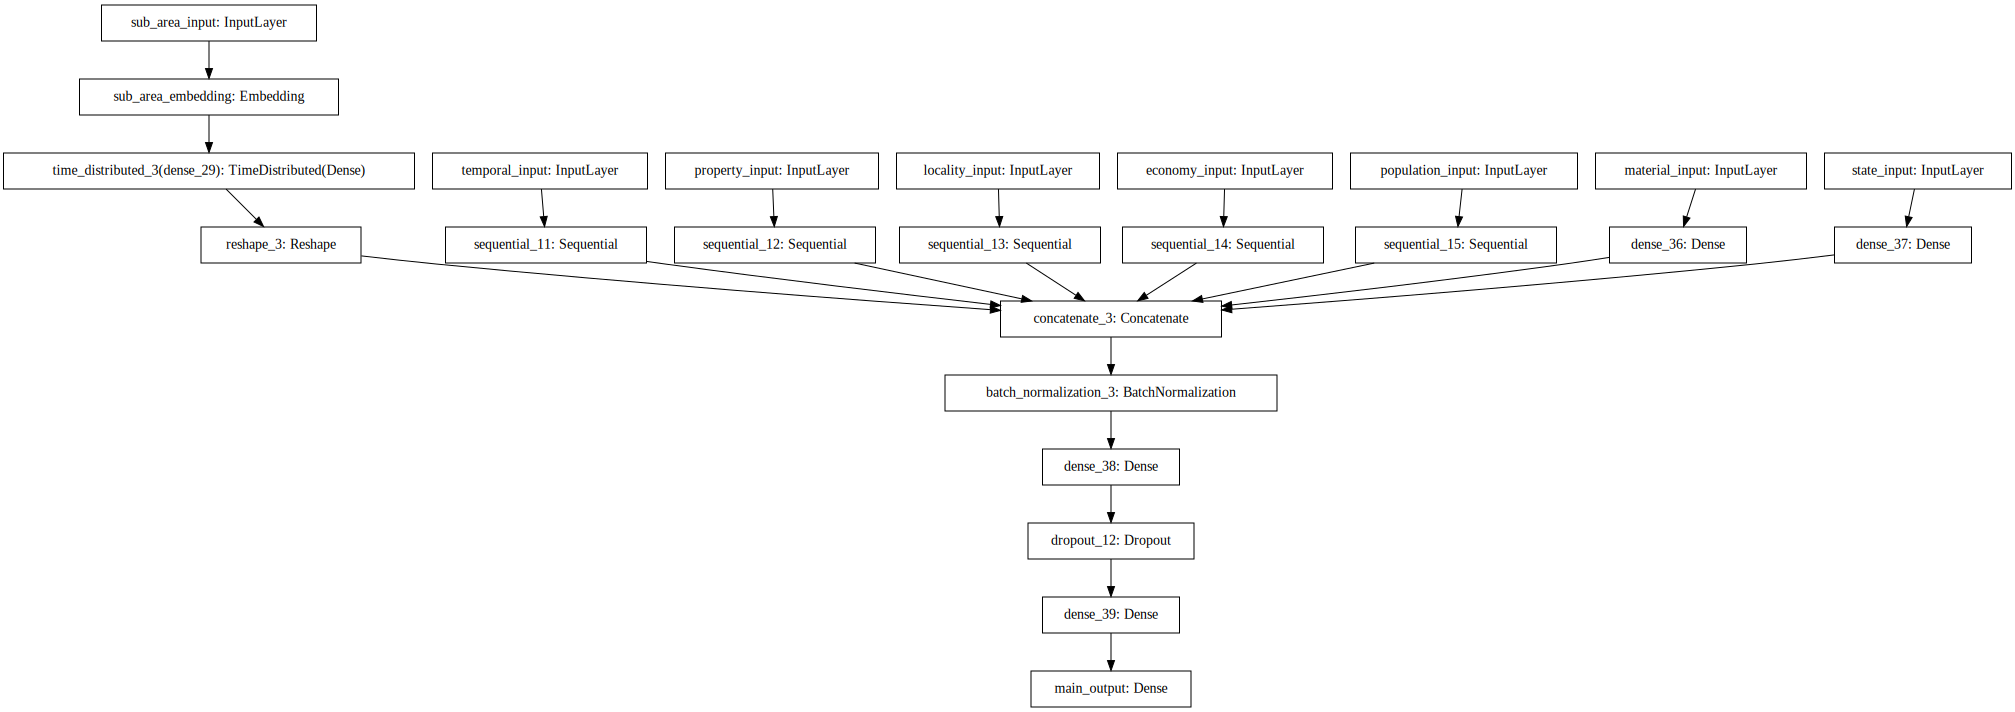

In [154]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

# Show the model in ipython notebook
SVG(model_to_dot(real_estate_price_model).create(prog='dot', format='svg'))

In [155]:
# Save the model as png file
from keras.utils.vis_utils import plot_model
plot_model(real_estate_price_model, to_file='/mnt/h/Kaggle/Competitions/Russian Bank/models/'+version_str+'/model.png', show_shapes=True)

In [156]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
    y_pred_log = K.log(y_pred + 1.)
    y_true_log = K.log(y_true + 1.)
    return K.sqrt(K.mean(K.square(y_pred_log - y_true_log), axis = -1))

In [158]:
real_estate_price_model.compile(optimizer = "adam", 
                          loss = root_mean_squared_logarithmic_error
                         )

### Train the model

In [159]:
epochs = 100

In [163]:
checkpointer = ModelCheckpoint(filepath="/mnt/h/Kaggle/Competitions/Russian Bank/models/" + version_str + "/" + "weights.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="/mnt/h/Kaggle/Competitions/Russian Bank/models/" + version_str + "/logs/",
                          histogram_freq=0, 
                          write_graph=True, 
                         # write_grads=True, 
                          write_images=False, 
                          embeddings_freq=5, 
                          embeddings_layer_names=[
                              'sub_area_embedding'
                          ], embeddings_metadata={
                              'sub_area_embedding':'/mnt/h/Kaggle/Competitions/Russian Bank/models/metadata/sub_area_metadata.tsv'
                          })
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
callbacks = [checkpointer, tensorboard, early_stopping]

In [164]:
real_estate_price_model.fit(x={
    'temporal_input' : train_split_df_temporal_features,
    'property_input' : train_split_df_property_features,
    'locality_input' : train_split_df_locality_features,
    'economy_input' : train_split_df_economy_features,
    'population_input' : train_split_df_population_features,
    'state_input' : train_split_df_categorical_features['state_refractored'],
    'material_input' : train_split_df_categorical_features['material'],
    'sub_area_input' : train_split_df_categorical_features['sub_area']},
                      y = train_split_df['price_doc'].values,
                      callbacks=callbacks,
                      verbose = 2,
                      validation_split=0.20,
                      shuffle=True,
                      epochs=epochs)

Train on 21938 samples, validate on 5485 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 2.47087, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v1.4/weights.00-2.47.hdf5
55s - loss: 4.1457 - val_loss: 2.4709
Epoch 2/100
Epoch 00001: val_loss improved from 2.47087 to 0.88499, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v1.4/weights.01-0.88.hdf5
33s - loss: 1.6061 - val_loss: 0.8850
Epoch 3/100
Epoch 00002: val_loss improved from 0.88499 to 0.34025, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v1.4/weights.02-0.34.hdf5
42s - loss: 0.5496 - val_loss: 0.3402
Epoch 4/100
Epoch 00003: val_loss improved from 0.34025 to 0.27329, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v1.4/weights.03-0.27.hdf5
41s - loss: 0.3073 - val_loss: 0.2733
Epoch 5/100
Epoch 00004: val_loss improved from 0.27329 to 0.26612, saving model to /mnt/h/Kaggle/Competitions/Russian Bank/models/v1.4/weights.04-0.27.hdf5
40s - loss: 0.2814

KeyboardInterrupt: 

In [165]:
real_estate_price_model.load_weights('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/weights.11-0.25.hdf5')

In [166]:
test_loss = real_estate_price_model.evaluate(x={
    'temporal_input' : train_split_df_temporal_features,
    'property_input' : train_split_df_property_features,
    'locality_input' : train_split_df_locality_features,
    'economy_input' : train_split_df_economy_features,
    'population_input' : train_split_df_population_features,
    'state_input' : train_split_df_categorical_features['state_refractored'],
    'material_input' : train_split_df_categorical_features['material'],
    'sub_area_input' : train_split_df_categorical_features['sub_area']},
                      y = train_split_df['price_doc'].values,
                      verbose = 2)
'Test loss: ', test_loss

('Test loss: ', 0.25667131966823464)

In [167]:
test_loss = real_estate_price_model.evaluate(x={
    'temporal_input' : test_split_df_temporal_features,
    'property_input' : test_split_df_property_features,
    'locality_input' : test_split_df_locality_features,
    'economy_input' : test_split_df_economy_features,
    'population_input' : test_split_df_population_features,
    'state_input' : test_split_df_categorical_features['state_refractored'],
    'material_input' : test_split_df_categorical_features['material'],
    'sub_area_input' : test_split_df_categorical_features['sub_area']},
                      y = test_split_df['price_doc'].values,
                      verbose = 2)
'Test loss: ', test_loss

('Test loss: ', 0.25278858171673274)

In [168]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [173]:
seed = 7
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [174]:
kfold.get_n_splits(final_train_df, final_train_df[[LABEL]].values)

10

In [175]:
eval_loss_scores = []

for idx, (train, test) in enumerate(kfold.split(final_train_df, final_train_df[[LABEL]].values.ravel())):
    
    temp_x, temp_y = final_train_df.ix[train, :], final_train_df.ix[train, :][LABEL].values
    temp_test_x, temp_test_y = final_train_df.ix[test, :], final_train_df.ix[test, :][LABEL].values
    
    temp_train_split_df_temporal_features = extract_temporal_features(temp_x)
    temp_test_split_df_temporal_features = extract_temporal_features(temp_test_x)
    
    temp_train_split_df_property_features = extract_property_place_features(temp_x)
    temp_test_split_df_property_features = extract_property_place_features(temp_test_x)
    
    temp_train_split_df_locality_features = extract_locality_features(temp_x)
    temp_test_split_df_locality_features = extract_locality_features(temp_test_x)
    
    temp_train_split_df_economy_features = extract_economy_features(temp_x)
    temp_test_split_df_economy_features = extract_economy_features(temp_test_x)
    
    temp_train_split_df_population_features = extract_population_features(temp_x)
    temp_test_split_df_population_features = extract_population_features(temp_test_x)
    
    temp_train_split_df_categorical_features = extract_categorical_features(temp_x)
    temp_test_split_df_categorical_features = extract_categorical_features(temp_test_x)
    
    print 'Cross validating.... step: ', idx
    
    temp_train_loss = real_estate_price_model.evaluate(x={
        'temporal_input' : temp_train_split_df_temporal_features,
        'property_input' : temp_train_split_df_property_features,
        'locality_input' : temp_train_split_df_locality_features,
        'economy_input' : temp_train_split_df_economy_features,
        'population_input' : temp_train_split_df_population_features,
        'state_input' : temp_train_split_df_categorical_features['state_refractored'],
        'material_input' : temp_train_split_df_categorical_features['material'],
        'sub_area_input' : temp_train_split_df_categorical_features['sub_area']},
                      y = temp_y,
                      verbose = 2)
    print 'Temp train loss: ', temp_train_loss, ' index: ', idx
    eval_loss_scores.append(temp_train_loss)
    
    temp_test_loss = real_estate_price_model.evaluate(x={
        'temporal_input' : temp_test_split_df_temporal_features,
        'property_input' : temp_test_split_df_property_features,
        'locality_input' : temp_test_split_df_locality_features,
        'economy_input' : temp_test_split_df_economy_features,
        'population_input' : temp_test_split_df_population_features,
        'state_input' : temp_test_split_df_categorical_features['state_refractored'],
        'material_input' : temp_test_split_df_categorical_features['material'],
        'sub_area_input' : temp_test_split_df_categorical_features['sub_area']},
                      y = temp_test_y,
                      verbose = 2)
    print 'Temp test loss: ', temp_test_loss, ' index: ', idx
    eval_loss_scores.append(temp_test_loss)
    
    
print eval_loss_scores


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Cross validating.... step:  0
Temp train loss:  0.257335607751  index:  0
Temp test loss:  0.24733681869  index:  0
Cross validating.... step:  1
Temp train loss:  0.256205141998  index:  1
Temp test loss:  0.256955237215  index:  1
Cross validating.... step:  2
Temp train loss:  0.255959373801  index:  2
Temp test loss:  0.259116310246  index:  2
Cross validating.... step:  3
Temp train loss:  0.256238041165  index:  3
Temp test loss:  0.256682146679  index:  3
Cross validating.... step:  4
Temp train loss:  0.256279371555  index:  4
Temp test loss:  0.256315248842  index:  4
Cross validating.... step:  5
Temp train loss:  0.256571986227  index:  5
Temp test loss:  0.253675635494  index:  5
Cross validating.... step:  6
Temp train loss:  0.256022065618  index:  6
Temp test loss:  0.258701146453  index:  6
Cross validating.... step:  7
Temp train loss:  0.256084526982  index:  7
Temp test loss:  0.258093024726  index:  7
Cross validating.... step:  8
Temp train loss:  0.256365214531  i

In [176]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(eval_loss_scores), np.std(eval_loss_scores)))

0.26% (+/- 0.00%)


In [177]:
real_estate_price_model.save('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/trained_model_0.25_val_loss.h5')

In [117]:
from keras.models import load_model

In [118]:
real_estate_price_model_duplicate = load_model('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/trained_model_0.22_val_loss.h5', custom_objects={"root_mean_squared_logarithmic_error":root_mean_squared_logarithmic_error})

In [179]:
test_temporal_features, test_property_features, test_locality_features, test_economy_features, test_population_features, test_categorical_features = format_input(test_split_df[:10])
test_preds = real_estate_price_model.predict(x={
    'temporal_input' : test_temporal_features,
    'property_input' : test_property_features,
    'locality_input' : test_locality_features,
    'economy_input' : test_economy_features,
    'population_input' : test_population_features,
    'state_input' : test_categorical_features['state_refractored'],
    'material_input' : test_categorical_features['material'],
    'sub_area_input' : test_categorical_features['sub_area']})
test_actuals = test_split_df[:10].price_doc.values

In [180]:
zip(test_actuals, test_preds.ravel())

[(1000000, 8965329.0),
 (6150000, 5593523.0),
 (15043290, 10756976.0),
 (3965000, 8996704.0),
 (9400000, 8185104.0),
 (6000000, 6850981.5),
 (8200000, 7513697.5),
 (4438471, 4747888.0),
 (6200000, 6144947.0),
 (3614688, 3157598.8)]

In [181]:
kaggle_test = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/test.csv/test.csv")

In [182]:
kaggle_test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [183]:
macro_df = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/macro.csv/macro.csv")

In [184]:
final_kaggle_df = pd.merge(kaggle_test, macro_df, on='timestamp')

In [185]:
final_kaggle_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9


In [186]:
final_kaggle_df = prepare_dataset(final_kaggle_df)

In [187]:
for continuous_norm_col in normalize_columns:
    scaler = norm_scalers[continuous_norm_col]
    scaled_values = scaler.transform(final_kaggle_df[[continuous_norm_col]].values)
    final_kaggle_df[continuous_norm_col + "_scaled_feature"] = scaled_values

In [188]:
for one_hot_col in one_hot_cols:
    l_scaler = ont_hot_scalers[one_hot_col][0]
    scaler = ont_hot_scalers[one_hot_col][1]
    r = l_scaler.transform(final_kaggle_df[[one_hot_col]].values)
    r = np.expand_dims(r, axis=1)
    scaled_values = scaler.transform(r)
    final_kaggle_df[one_hot_col + "_scaled_feature"] = list(scaled_values)

In [189]:
for label_col in label_cols:
    label_enc = label_scalers[label_col]
    encoded_values = label_enc.transform(final_kaggle_df[[label_col]].values)
    final_kaggle_df[label_col + "_scaled_feature"] = encoded_values

In [190]:
[c for c in final_kaggle_df.columns.tolist() if "_scaled_feature" in c]

['micex_cbi_tr_scaled_feature',
 'unemployment_scaled_feature',
 'apartment_build_scaled_feature',
 'railroad_station_avto_min_scaled_feature',
 'rts_scaled_feature',
 'pop_migration_scaled_feature',
 'work_all_scaled_feature',
 'max_floor_scaled_feature',
 'housing_fund_sqm_scaled_feature',
 'heating_share_scaled_feature',
 'catering_km_scaled_feature',
 'zd_vokzaly_avto_km_scaled_feature',
 'mortality_scaled_feature',
 'water_km_scaled_feature',
 'green_part_1000_scaled_feature',
 'deposits_rate_scaled_feature',
 'park_km_scaled_feature',
 'big_road1_km_scaled_feature',
 'hospice_morgue_km_scaled_feature',
 'metro_km_avto_scaled_feature',
 'ekder_male_scaled_feature',
 'female_f_scaled_feature',
 'deposits_growth_scaled_feature',
 'usdrub_scaled_feature',
 'deposits_value_scaled_feature',
 'gdp_annual_growth_scaled_feature',
 'big_church_km_scaled_feature',
 'exhibition_km_scaled_feature',
 'area_m_scaled_feature',
 'young_male_scaled_feature',
 'ekder_all_scaled_feature',
 'divorce_

In [191]:
kaggle_temporal_features, kaggle_property_features, kaggle_locality_features, kaggle_economy_features, kaggle_population_features, kaggle_categorical_features = format_input(final_kaggle_df)
kaggle_preds = real_estate_price_model.predict(x={
    'temporal_input' : kaggle_temporal_features,
    'property_input' : kaggle_property_features,
    'locality_input' : kaggle_locality_features,
    'economy_input' : kaggle_economy_features,
    'population_input' : kaggle_population_features,
    'state_input' : kaggle_categorical_features['state_refractored'],
    'material_input' : kaggle_categorical_features['material'],
    'sub_area_input' : kaggle_categorical_features['sub_area']})

In [192]:
final_kaggle_df['price_doc'] = kaggle_preds

In [193]:
final_kaggle_df['price_doc']

0        6091260.0
1        7621912.0
2        5901579.5
3        7160403.0
4        5148064.0
5        8885802.0
6        4799355.0
7        4075868.0
8        5328503.0
9        4843736.0
10       6873499.0
11       4890808.0
12       4357015.0
13       4411308.0
14       5515977.5
15       6245361.0
16      12693578.0
17      13694822.0
18       6223145.5
19      12390278.0
20       6895234.0
21       8917516.0
22       8090024.0
23       8483940.0
24       5255595.0
25      10034618.0
26      10508640.0
27       7819937.0
28       3144108.0
29       7716635.5
           ...    
7632    35145488.0
7633    34686472.0
7634    37453340.0
7635    35543336.0
7636    34921200.0
7637    35086264.0
7638    34785384.0
7639    35598932.0
7640    35557420.0
7641    34417004.0
7642    36356344.0
7643    35481448.0
7644    36443536.0
7645    34557164.0
7646    36116244.0
7647    36303456.0
7648    36367688.0
7649    35612724.0
7650    35585164.0
7651    35875512.0
7652    36600544.0
7653    3609

In [194]:
final_kaggle_df[['id', 'price_doc']]

,id,price_doc
0,30474,6091260.0
1,30475,7621912.0
2,30476,5901579.5
3,30477,7160403.0
4,30478,5148064.0
5,30479,8885802.0
6,30480,4799355.0
7,30481,4075868.0
8,30482,5328503.0
9,30483,4843736.0


In [195]:
final_kaggle_df[['id', 'price_doc']].to_csv("/mnt/h/Kaggle/Competitions/Russian Bank/models/v" + str(version) + "/submission.csv", index=False) # output submission csv file